# Neural Network model to identify yoga poses

This notebook explores model approaches for an optimal classification of yoga poses.

## Imports

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score


from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LeakyReLU

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

## Data Preprocessing

First, we download import the pose data into the notebook. For the tryout, we started out without visibility and presence parameters, only using coordinates. This of course can be changed at any time. We a currently in the phase of trying out what would work best for the model accuracy.

In [13]:
df = pd.read_csv('pose_landmark_data_10.csv')
cols_to_drop = [col for col in df.columns if col.endswith('visibility') or col.endswith('presence')]
# cols_to_drop = [col for col in df.columns if col.endswith('presence')]
# cols_to_drop = [col for col in df.columns if col.endswith('visibility')]
# cols_to_drop.append(df['filename'])
df = df.drop(columns= cols_to_drop)
df

,kp0_x,kp0_y,kp0_z,kp1_x,kp1_y,kp1_z,kp2_x,kp2_y,kp2_z,kp3_x,...,kp30_x,kp30_y,kp30_z,kp31_x,kp31_y,kp31_z,kp32_x,kp32_y,kp32_z,pose
0,0.385343,0.364360,0.361979,0.362940,0.360878,0.348136,0.392381,0.378489,0.382307,0.140542,...,0.993006,0.992317,0.992891,0.997086,0.997190,0.996694,0.991000,0.988940,0.989357,downdog
1,0.717402,0.730172,0.730780,0.728248,0.727160,0.717752,0.701235,0.668441,0.666630,0.802421,...,0.989424,0.995805,0.991026,0.999337,0.999193,0.998262,0.995215,0.996262,0.993360,downdog
2,0.530589,0.515072,0.511203,0.516099,0.514304,0.486886,0.528156,0.471784,0.498650,0.314393,...,0.990774,0.987842,0.991232,0.992660,0.992256,0.995080,0.990886,0.986480,0.989551,downdog
3,0.492500,0.505676,0.507709,0.506006,0.507219,0.524815,0.488527,0.524411,0.496102,0.670937,...,0.996396,0.999596,0.997484,0.999946,0.999911,0.999758,0.997172,0.998048,0.995672,downdog
4,0.443791,0.431420,0.429302,0.429864,0.427988,0.413434,0.443713,0.402149,0.404504,0.264853,...,0.994291,0.992315,0.994823,0.977046,0.972214,0.992173,0.988848,0.988861,0.989036,downdog
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,0.164464,0.146368,0.145295,0.146610,0.145890,0.148178,0.182718,0.235555,0.264997,0.272738,...,0.972252,0.915284,0.962605,0.975116,0.926694,0.980691,0.864805,0.856140,0.892713,halfmoon_left
1680,0.254658,0.245960,0.245923,0.248003,0.248975,0.254913,0.271564,0.319827,0.351983,0.315301,...,0.985160,0.995128,0.984632,0.993316,0.954791,0.994418,0.906581,0.948635,0.939454,halfmoon_left
1681,0.136031,0.121478,0.121486,0.121891,0.121928,0.127988,0.153315,0.215636,0.221753,0.198252,...,0.988423,0.998257,0.990037,0.999555,0.996101,0.999795,0.987916,0.994300,0.991385,halfmoon_left
1682,0.713741,0.724633,0.725406,0.721830,0.720996,0.721073,0.703423,0.681243,0.657015,0.689235,...,0.992578,0.995644,0.993351,0.999857,0.999493,0.999216,0.998226,0.997230,0.998058,halfmoon_left


In [14]:
n_rows_to_keep = 300

cobra_df = df[df['pose'] == 'cobra']
non_cobra_df = df[df['pose'] != 'cobra']
cobra_df_lite = cobra_df.sample(n = n_rows_to_keep, random_state=2)
df = pd.concat([non_cobra_df, cobra_df_lite])

# revolved_triangle_df = df[df['pose'] == 'revolved_triangle']
# non_revolved_triangle_df = df[df['pose'] != 'revolved_triangle']
# revolved_triangle_df_lite = revolved_triangle_df.sample(n = n_rows_to_keep, random_state=2)
# df = pd.concat([non_revolved_triangle_df, revolved_triangle_df_lite])

df['pose'].value_counts()

pose
cobra             300
downdog           205
camel             184
plow              182
warrior_left      105
plank             100
goddess            88
dance_right        82
halfmoon_left      75
dance_left         57
warrior_right      51
halfmoon_right     49
akarna_right       35
tree_left          33
akarna left        21
tree_right         12
Name: count, dtype: int64

We then split the data into independent variables (X) and dependent variables (y). The validation split can be either done manually here (currently executed option) or within the model fitting with the data. As described below, the results are a lot better with the validation split within the model fitting (how it is not currently done). This should not be the case and needs to investigated further.



Afterwards, we transform the targets into number values, scale the features, and OneHotEncode the targets.

In [15]:
X = df[df['pose'].isin(["downdog", "warrior_right", "warrior_left", "camel", "dance_left", "tree_left", "akarna_right", "akarna left", "plow", "goddess", "tree_right", "plank", "dance_right", "cobra", "halfmoon_right", "halfmoon_left"])].iloc[:, :len(df.columns)-1]
# X = df.iloc[:, :len(df.columns)-1]

y = df.loc[df['pose'].isin(["downdog", "warrior_right", "warrior_left", "camel", "dance_left", "tree_left", "akarna_right", "akarna left", "plow", "goddess", "tree_right", "plank", "dance_right", "cobra", "halfmoon_right", "halfmoon_left"]), 'pose']
# y = df['pose']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=13,
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  random_state=13,
                                                  stratify=y_train)

numdict_y = {label: idx for idx, label in enumerate(np.unique(y))}
y_train_numerical = np.array([numdict_y[label] for label in y_train])
y_test_numerical = np.array([numdict_y[label] for label in y_test])
y_val_numerical = np.array([numdict_y[label] for label in y_val])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Saving scaler for app.py
joblib.dump(scaler, 'scaler.pkl')

y_train_encoded = to_categorical(y_train_numerical)
y_test_encoded = to_categorical(y_test_numerical)
y_val_encoded = to_categorical(y_val_numerical)


## Model Setup

In [16]:

def model_init():
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(len(numdict_y), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = model_init()


## Model Fitting and Testing

Here fit the model on the train data. For validation, we have two options: 

1. We create the validation data manually. The advantage is that we can stratify the split, meaning keeping it proportionally equivalent amongs targets, no matter the size of the data points for each (which fluctuata a lot).This is how it is currently done. The results are surprisingly worse than with option 2.

2. We can create a direct validation split within fitting the model with validation_split. This cuts off the lower X% number given. The results are a lot better. While therefore theoretically preferable, this should not be the case and needs to investigated further.

In [17]:
len(X_train_scaled)

884

Epoch 1/50
7/7 [==============================] - 1s 63ms/step - loss: 2.4697 - accuracy: 0.3088 - val_loss: 1.5750 - val_accuracy: 0.6018
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 1.2551 - accuracy: 0.6742 - val_loss: 1.0597 - val_accuracy: 0.7466
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 0.8596 - accuracy: 0.7726 - val_loss: 0.8022 - val_accuracy: 0.8100
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.6873 - accuracy: 0.8269 - val_loss: 0.6493 - val_accuracy: 0.8507
Epoch 5/50
7/7 [==============================] - 0s 17ms/step - loss: 0.5619 - accuracy: 0.8405 - val_loss: 0.5528 - val_accuracy: 0.8597
Epoch 6/50
7/7 [==============================] - 0s 17ms/step - loss: 0.5319 - accuracy: 0.8416 - val_loss: 0.5247 - val_accuracy: 0.8597
Epoch 7/50
7/7 [==============================] - 0s 16ms/step - loss: 0.5382 - accuracy: 0.8495 - val_loss: 0.4726 - val_accuracy: 0.8869
Epoch 8/50
7/7 [===========

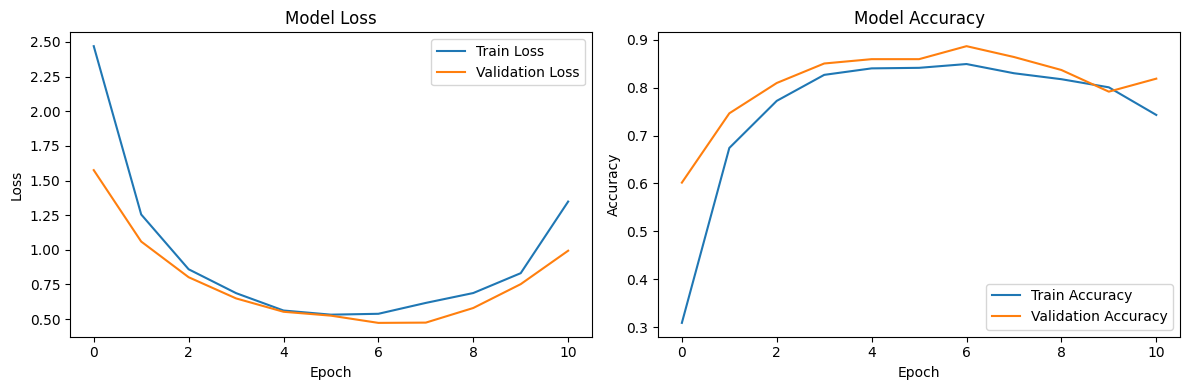

15/15 [==============================] - 0s 10ms/step - loss: 0.7545 - accuracy: 0.8966
Test Accuracy: 89.66%
Test Loss: 0.7544629573822021


In [18]:


es = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    restore_best_weights=True,
)

history = model.fit(
    X_train_scaled,
    y_train_encoded,
    epochs=50,
    batch_size = 128,
    # validation_split = 0.3,
    validation_data=(X_val_scaled, y_val_encoded),
    verbose=1,
    callbacks=[es]
)

model.save('nn.keras')
model.save('nn.tflite')

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

results = model.evaluate(X_test_scaled, y_test_encoded, verbose=1)
print(f'Test Accuracy: {results[1]*100:.2f}%')
print(f'Test Loss: {results[0]}')
